# Ensemble Learning Code Tutorial

<b><u>[목적]</u></b>
- Variance를 낮추기위한 Bagging의 대표적인 모델 RandomForest를 돌려봄
- Bias를 낮추기위한 Boosting의 대표적인 모델 Adaboost를 돌려봄
- 모델이 복잡해 짐에 따라 설명력이 떨어짐

<b><u>[Process]</u></b>
- Data Path = 'https://github.com/GonieAhn/Data-Science-online-course-from-gonie/tree/main/Data%20Store'•Define X's & Y
- Transform Y (Numeric --> Category)
- Split Train & Valid data set
- Modeling
    - 주의
        - Ensemble Learning은 Random성이 많이 들어가기 때문에 같은 결과를 도출하려면 Seed 고정을 해주어야 함
        - 예를 들어, Data Sampling 혹은 Feature Sampling을 할때 Random Seed를 고정해야 같은 결과를 도출할 수 있음
- 해석

In [1]:
import os
import gc
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from collections import Counter

In [3]:
%%time
# Data Load 
data = pd.read_csv("../Data Store/TOY_DATA.csv")
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (3500, 357)
Wall time: 233 ms


<b><u>[Data Cleaning & Change Regression P to Classification P]</u></b>
- Data Cleaning 진행
- Regression Problem ==> Classification Problem 상위 30% [Class 1]과 하위 30% [Class 0]
    - 이렇게 하는 이유는 결국 우리는 상위 n%와 하위 n%의 차이를 알고 싶은 것
    - 복잡한 Regression 문제보다 1 또는 0을 마추는 Classification Problem으로 전환해보자
    - 그리고 상위 n%가 나오는 Rule을 도출해보자 (해석력을 얻기 위함)
    - 이렇게 할 경우 데이터 손실이 있기 때문에 데이터가 많은 경우 써먹어보자

In [5]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
print("Data Shape : {}".format(data.shape))

Data Shape : (3500, 357)


In [7]:
per_70 = np.percentile(data['Y'], 70)
per_30 = np.percentile(data['Y'], 30)
print(">>>> 70 Percentile : {}".format(per_70))
print(">>>> 30 Percentile : {}".format(per_30))

>>>> 70 Percentile : 0.821760391
>>>> 30 Percentile : 0.7269621028


In [8]:
data = data[(data['Y'] >= per_70) | (data['Y'] <= per_30)]
data.reset_index(inplace=True, drop=True)
print('Data shape : {}'.format(data.shape))

Data shape : (2101, 357)


In [9]:
data['Label'] = 3
data['Label'].iloc[np.where(data['Y'] >= per_70)[0]] = 1
data['Label'].iloc[np.where(data['Y'] <= per_30)[0]] = 0
print("Unique Label : {}".format(set(data['Label'])))

Unique Label : {0, 1}


In [10]:
Counter(data['Label'])

Counter({1: 1051, 0: 1050})

In [11]:
# X1, X2, X3는 Y에 영향을 너무 많이 미치는 변수이기 때문에 빼고 다른 변수에서 중요도를 찾아보자
Y = data['Label']
X = data.drop(columns=['Y', 'X1', 'X2', 'X3', 'Label'])

In [12]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2021)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))

>>>> # of Train data : 1470
>>>> # of valid data : 631


<b><u>[Random Forest]</u></b>
- Hyperparameter tuning
    - estimators, depth
    - Random Forest는 이 두개만 조절해도 좋은 결과를 얻을 수 있음
    - GridSearchCV를 사용하지 않고 For Loop를 돌리는 이유
        - 내가 원하는 결과를 저장하고 Display 하고 싶음
        - 내가 원하는 결과를 실시간 Display 하면서 그때 그때 파라미터 튜닝에 대한 대처를 하고 싶음

In [14]:
# RandomForest Hyperparameter
estimators = [30, 40, 50, 60]
depth = [10, 15, 20]

# Modeling
save_est = []
save_dep = []
save_acc = []

cnt = 0
for est in estimators:
    for dep in depth:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print("Number of Estimators : {}, Max Depth : {}".format(est, dep))
        
        #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        model = RandomForestClassifier(n_estimators=est, max_depth=dep, random_state=119,
                                       criterion='entropy', max_features='auto', 
                                       bootstrap=True, oob_score=True) # if you use "oob_score=True", get long time for training
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_dep.append(dep)
        save_acc.append((cm_test[0,0] + cm_test[1,1])/cm_test.sum())

>>> 0 <<<
Number of Estimators : 30, Max Depth : 10
Train Confusion Matrix
[[708  32]
 [  9 721]]
Train Acc : 0.972108843537415
Test Confusion Matrix
[[230  80]
 [ 63 258]]
TesT Acc : 0.7733755942947702
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 30, Max Depth : 15
Train Confusion Matrix
[[737   3]
 [  0 730]]
Train Acc : 0.9979591836734694
Test Confusion Matrix
[[223  87]
 [ 80 241]]
TesT Acc : 0.7353407290015848
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 30, Max Depth : 20
Train Confusion Matrix
[[738   2]
 [  0 730]]
Train Acc : 0.998639455782313
Test Confusion Matrix
[[233  77]
 [ 71 250]]
TesT Acc : 0.7654516640253566
-----------------------------------------------------------------------
------------------------------

In [15]:
# Best Param Display
print(">>> {} <<<\nBest Test Acc : {}\nBest n_estimators : {}\nBest Max_Depth : {}".format(np.argmax(save_acc),
                                                                                           save_acc[np.argmax(save_acc)], 
                                                                                           save_est[np.argmax(save_acc)],
                                                                                           save_dep[np.argmax(save_acc)]))

>>> 6 <<<
Best Test Acc : 0.7892234548335975
Best n_estimators : 50
Best Max_Depth : 10


<b><u>[주의]</u></b>
- 현재는 모델을 Parameter Tuning을 하면서 모델을 저정하지 않고 있음
- 나중에 Training 시간이 매우 오래 걸리는 알고리즘이면 Parameter Tuning을 하면서 모델을 저장해야함
- Class09 LightGBM Tutorial Code 에 모델을 저장하고 Best Model을 불러오는 과정이 있음

In [16]:
# Best Model
best_model = RandomForestClassifier(n_estimators=save_est[np.argmax(save_acc)], max_depth=save_dep[np.argmax(save_acc)], random_state=119,
                               criterion='entropy', max_features='auto', 
                               bootstrap=True, oob_score=True) # if you use "oob_score=True", get long time for training
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       oob_score=True, random_state=119)

In [17]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum())) 

Train Confusion Matrix
[[721  19]
 [  5 725]]
Train Acc : 0.9836734693877551
Test Confusion Matrix
[[228  82]
 [ 51 270]]
TesT Acc : 0.7892234548335975


In [18]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

        Score Feature
0    0.103592     X23
1    0.060653     X22
2    0.034934    X244
3    0.020613    X247
4    0.013675    X246
..        ...     ...
348  0.000000    X120
349  0.000000    X117
350  0.000000    X114
351  0.000000    X111
352  0.000000    X108

[353 rows x 2 columns]


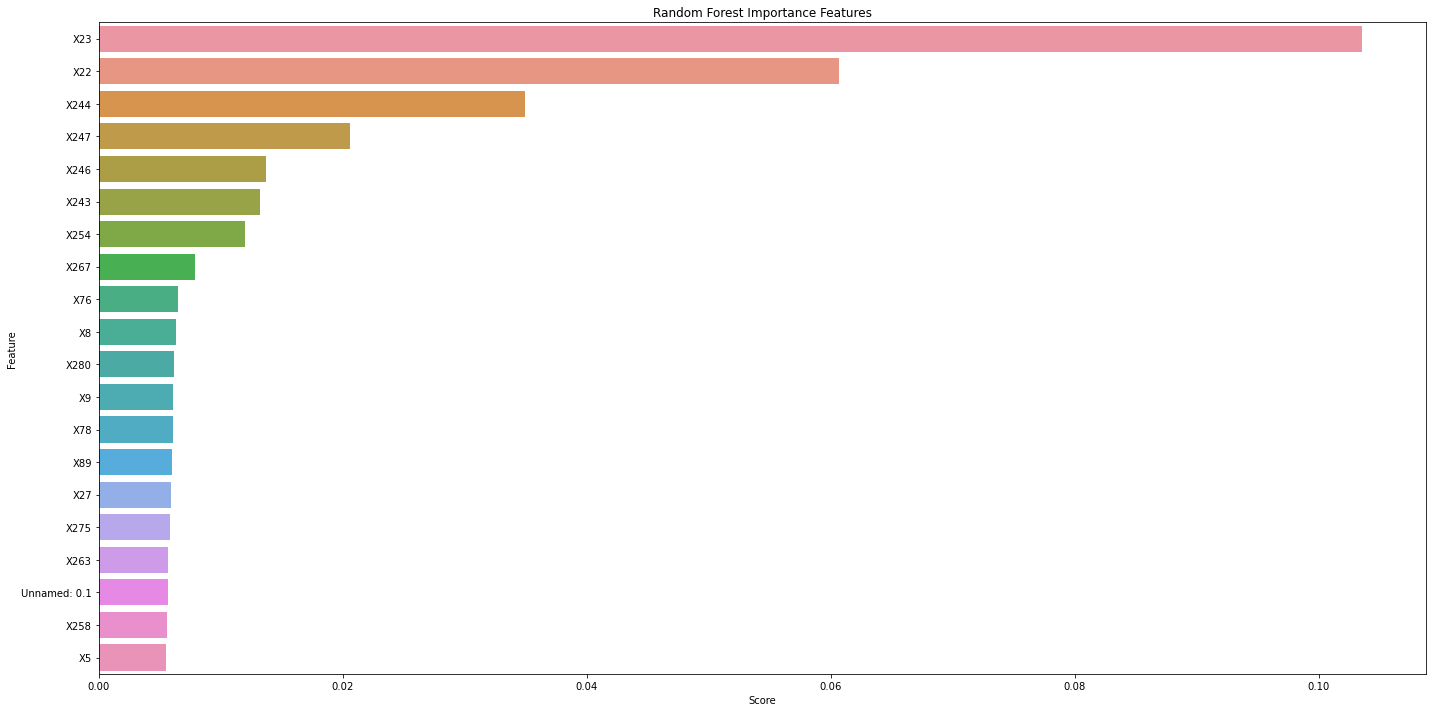

In [19]:
# Importance Score Top 20
feature_map_20 = feature_map.iloc[:20]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('Random Forest Importance Features')
plt.tight_layout()
plt.show()

<b><u>[AdaBoost]</u></b>
- Hyperparameter tuning
    - estimators, learning Rate
    - AdaBoost도이 두개만 조절해도 좋은 결과를 얻을 수 있음
    - GridSearchCV를 사용하지 않고 For Loop를 돌리는 이유
        - 내가 원하는 결과를 저장하고 Display 하고 싶음
        - 내가 원하는 결과를 실시간 Display 하면서 그때 그때 파라미터 튜닝에 대한 대처를 하고 싶음

In [25]:
# AdaBoost Hyperparameter
estimators = [50, 70, 90, 100]
learning = [0.001, 0.01, 0.03, 0.05]

# Modeling
save_est = []
save_lr = []
save_acc = []

cnt = 0
for est in estimators:
    for lr in learning:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print("Number of Estimators : {}, Learning Rate : {}".format(est, lr))
        
        #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        model = AdaBoostClassifier(n_estimators=est, learning_rate=lr, random_state=119)
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_lr.append(lr)
        save_acc.append((cm_test[0,0] + cm_test[1,1])/cm_test.sum())

>>> 0 <<<
Number of Estimators : 50, Learning Rate : 0.001
Train Confusion Matrix
[[471 269]
 [ 71 659]]
Train Acc : 0.7687074829931972
Test Confusion Matrix
[[199 111]
 [ 33 288]]
TesT Acc : 0.7717908082408875
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 50, Learning Rate : 0.01
Train Confusion Matrix
[[510 230]
 [102 628]]
Train Acc : 0.7741496598639456
Test Confusion Matrix
[[213  97]
 [ 44 277]]
TesT Acc : 0.7765451664025357
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 50, Learning Rate : 0.03
Train Confusion Matrix
[[510 230]
 [102 628]]
Train Acc : 0.7741496598639456
Test Confusion Matrix
[[213  97]
 [ 44 277]]
TesT Acc : 0.7765451664025357
-----------------------------------------------------------------------
---------

In [26]:
print(">>> {} <<<\nBest Test Acc : {}\nBest n_estimators : {}\nBest Learning Rate : {}".format(np.argmax(save_acc),
                                                                                               save_acc[np.argmax(save_acc)], 
                                                                                               save_est[np.argmax(save_acc)],
                                                                                               save_lr[np.argmax(save_acc)]))

>>> 15 <<<
Best Test Acc : 0.7828843106180665
Best n_estimators : 100
Best Learning Rate : 0.05


<b><u>[주의]</u></b>
- 현재는 모델을 Parameter Tuning을 하면서 모델을 저정하지 않고 있음
- 나중에 Training 시간이 매우 오래 걸리는 알고리즘이면 Parameter Tuning을 하면서 모델을 저장해야함
- Class09 LightGBM Tutorial Code 에 모델을 저장하고 Best Model을 불러오는 과정이 있음

In [27]:
best_model = AdaBoostClassifier(n_estimators=save_est[np.argmax(save_acc)], learning_rate=save_lr[np.argmax(save_acc)], random_state=119)
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))

Train Confusion Matrix
[[515 225]
 [ 88 642]]
Train Acc : 0.7870748299319728
Test Confusion Matrix
[[214  96]
 [ 41 280]]
TesT Acc : 0.7828843106180665


In [28]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

     Score Feature
0     0.49     X23
1     0.06     X27
2     0.06    X244
3     0.05    X247
4     0.05    X113
..     ...     ...
348   0.00    X103
349   0.00    X102
350   0.00    X101
351   0.00    X100
352   0.00     X10

[353 rows x 2 columns]


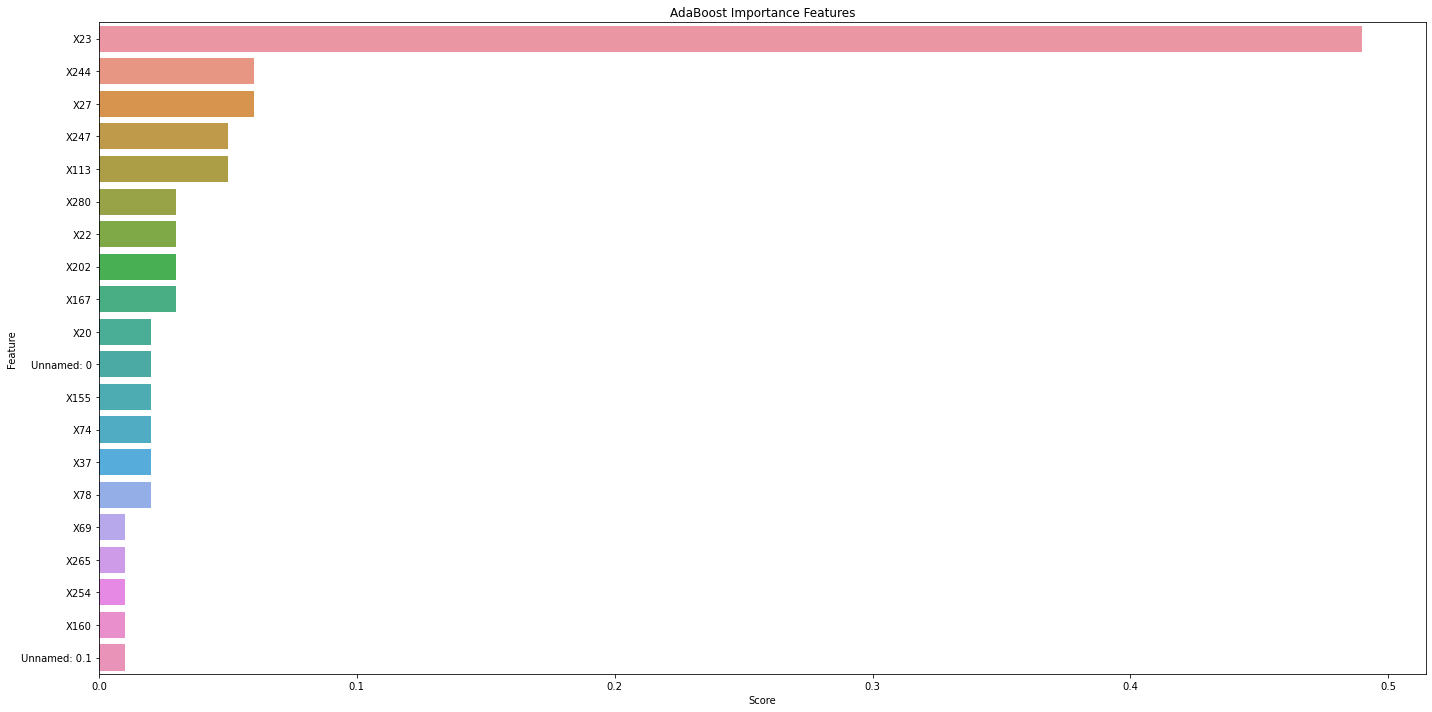

In [29]:
# Importance Score Top 20
feature_map_20 = feature_map.iloc[:20]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('AdaBoost Importance Features')
plt.tight_layout()
plt.show()